In [1]:
# In[1]:

import os, sys, shutil
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import cv2
import pandas as pd
import json
import datetime
import csv, h5py
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold


In [2]:
# In[2]:

from MODULES.Generators import get_generator, DataGenerator
from MODULES.Networks import WaveletScatteringTransform, ResNet 
from MODULES.Networks import SelectChannel, TransposeChannel, ScaleByInput, Threshold 
from MODULES.Losses import other_metrics_binary_class
from MODULES.Constants import _Params, _Paths
from MODULES.Utils import get_class_threshold, standardize, commonelem_set
from MODULES.Utils import _HEAT_MAP_DIFF
from MODULES.Utils import get_roc_curve, compute_gradcam, get_roc_curve_sequence, plot_confusion_matrix
from MODULES.Utils import get_mean_roc_curve_sequence, get_multi_roc_curve_sequence
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model
from tensorflow.keras.layers import Input, Average, Lambda, Multiply, Add, GlobalAveragePooling2D, Activation
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from tensorflow.compat.v1.logging import INFO, set_verbosity
import matplotlib.pyplot as plt
import datetime

%load_ext autoreload
%autoreload 2


In [3]:
# In[3]:

# ### DEVICES

physical_devices_GPU = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices_GPU))

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
print("Num CPUs:", len(physical_devices_CPU)) 

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)


In [4]:
# In[4]:

# ### MODEL AND RUN SELECTION
HEIGHT, WIDTH, CHANNELS, IMG_COLOR_MODE, MSK_COLOR_MODE, NUM_CLASS, \
    KS1, KS2, KS3, DL1, DL2, DL3, NF, NFL, NR1, NR2, DIL_MODE, W_MODE, LS, \
    SHIFT_LIMIT, SCALE_LIMIT, ROTATE_LIMIT, ASPECT_LIMIT, U_AUG, \
    TRAIN_SIZE, VAL_SIZE, DR1, DR2, CLASSES, IMG_CLASS, MSK_FLOAT, MSK_THRESHOLD, \
    MRA, MRALEVEL, MRACHANNELS, WAVELET, WAVEMODE, WST, WST_J, WST_L, WST_FIRST_IMG, \
    SCALE_BY_INPUT, SCALE_THRESHOLD = _Params() 
    
TRAIN_IMG_PATH, TRAIN_MSK_PATH, TRAIN_MSK_CLASS, VAL_IMG_PATH, \
        VAL_MSK_PATH, VAL_MSK_CLASS = _Paths()


In [5]:
# In[5]:

# ### Additional or modified network or fit parameters

NEW_RUN = True
NEW_MODEL_NUMBER = False

UPSAMPLE = False
UPSAMPLE_KERNEL = (2,2)

KS1=(3, 3)
KS2=(3, 3)
KS3=(3, 3)

WSTCHANNELS = 50

RESNET_DIM_1 = 75
RESNET_DIM_2 = 85

SCALE_BY_INPUT = False
SCALE_THRESHOLD = 0.6
SCALE_TO_SPAN = False
SPAN = 1.0

ATT = 'mh'
HEAD_SIZE = 64
NUM_HEAD = 2 
VALUE_ATT = True

BLUR_ATT = False
BLUR_ATT_STD = 0.1
BLUR_SBI = False
BLUR_SBI_STD = 0.1

NR1 = 2

PREP = True
STEM = True

KFOLD = 'Simple' # 'Simple','Strati','Group'

VAL_SIZE = 15

OPTIMIZER = Adam(learning_rate=0.002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=True)


In [6]:
# In[6]:

model_selection = 'model_' + str(NF) + 'F_' + str(NR1) + 'R1_' + str(NR2) + 'R2'

if NEW_MODEL_NUMBER:
    model_number = str(datetime.datetime.now())[0:10] + '_' + \
                   str(datetime.datetime.now())[11:13] + '_' + \
                   str(datetime.datetime.now())[14:16]
else:
    model_number = '2021-02-16_11_28'
    

In [7]:
print(f"\n HEIGHT={HEIGHT}\n WIDTH={WIDTH}\n CHANNELS={CHANNELS}\n NUM_CLASS={NUM_CLASS}") 
print(f"\n KS1={KS1}\n KS2={KS2}\n KS3={KS3}\n DL1={DL1}\n DL2={DL2}\n DL3={DL3}\n NR1={NR1}\n NF={NF}")
print(f"\n OPT_LR={K.eval(OPTIMIZER.lr)}\n OPT_B1={K.eval(OPTIMIZER.beta_1)}\n OPT_B2={K.eval(OPTIMIZER.beta_2)}")
print(f" OPT_EPS={K.eval(OPTIMIZER.epsilon)}\n OPT_AMS={K.eval(OPTIMIZER.amsgrad)}")
print(f"\n PREP={PREP}\n STEM={STEM}")
print(f"\n WST={WST}\n WST_J={WST_J}\n WST_L={WST_L}\n WST_FIRST_IMG={WST_FIRST_IMG}")
print(f"\n RESNET_DIM_1={RESNET_DIM_1}\n RESNET_DIM_2={RESNET_DIM_2}")
print(f"\n MRACHANNELS={MRACHANNELS}\n MSK_FLOAT={MSK_FLOAT}\n MSK_THRESHOLD={MSK_THRESHOLD}")
print(f"\n TRAIN_SIZE={TRAIN_SIZE}\n VAL_SIZE={VAL_SIZE}")
print(f"\n SCALE_BY_INPUT={SCALE_BY_INPUT}\n SCALE_THRESHOLD={SCALE_THRESHOLD}")
print(f"\n SCALE_TO_SPAN={SCALE_TO_SPAN}\n SPAN={SPAN}")
print(f"\n ATT={ATT}\n HEAD_SIZE={HEAD_SIZE}\n NUM_HEAD={NUM_HEAD}\n VALUE_ATT={VALUE_ATT}")
print(f"\n BLUR_ATT={BLUR_ATT}\n BLUR_ATT_STD={BLUR_ATT_STD}\n BLUR_SBI={BLUR_SBI}\n BLUR_SBI_STD={BLUR_SBI_STD}")
print(f"\n KFOLD={KFOLD}")
print(f"\n NEW_RUN={NEW_RUN}\n NEW_MODEL_NUMBER={NEW_MODEL_NUMBER}")
print(f"\n MODEL={model_selection}\n MODEL_NUMBER={model_number}")


 HEIGHT=300
 WIDTH=340
 CHANNELS=1
 NUM_CLASS=2

 KS1=(3, 3)
 KS2=(3, 3)
 KS3=(3, 3)
 DL1=(1, 1)
 DL2=(2, 2)
 DL3=(3, 3)
 NR1=2
 NF=17

 OPT_LR=0.0020000000949949026
 OPT_B1=0.8999999761581421
 OPT_B2=0.9990000128746033
 OPT_EPS=1e-07
 OPT_AMS=True

 PREP=True
 STEM=True

 WST=True
 WST_J=2
 WST_L=6
 WST_FIRST_IMG=True

 RESNET_DIM_1=75
 RESNET_DIM_2=85

 MRACHANNELS=1
 MSK_FLOAT=False
 MSK_THRESHOLD=0.3

 TRAIN_SIZE=15
 VAL_SIZE=15

 SCALE_BY_INPUT=False
 SCALE_THRESHOLD=0.6

 ATT=mh
 HEAD_SIZE=64
 NUM_HEAD=2
 VALUE_ATT=True

 BLUR_ATT=False
 BLUR_ATT_STD=0.1
 BLUR_SBI=False
 BLUR_SBI_STD=0.1

 KFOLD=Simple

 NEW_RUN=True
 NEW_MODEL_NUMBER=False

 MODEL=model_17F_2R1_0R2
 MODEL_NUMBER=2021-02-16_11_28


In [8]:
# In[7]:
    
K.clear_session()

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    wst_model = WaveletScatteringTransform(input_shape=(HEIGHT, WIDTH, CHANNELS),
                                           upsample=UPSAMPLE,
                                           upsample_kernel=UPSAMPLE_KERNEL)

    resnet_model = ResNet(input_shape_1=(RESNET_DIM_1, RESNET_DIM_2, WSTCHANNELS),
                           input_shape_2=(RESNET_DIM_1, RESNET_DIM_2, 1),
                           num_class=NUM_CLASS,
                           ks1=KS1, ks2=KS2, ks3=KS3, 
                           dl1=DL1, dl2=DL2, dl3=DL3,
                           filters=NF,resblock1=NR1,
                           r_filters=NFL, resblock2=NR2,
                           dil_mode=DIL_MODE, 
                           sp_dropout=DR1,re_dropout=DR2,
                           prep=PREP,
                           stem=STEM,
                           mask_float=MSK_FLOAT,
                           mask_threshold=MSK_THRESHOLD,
                           att=ATT,
                           head_size=HEAD_SIZE,
                           num_heads=NUM_HEAD,
                           value_att=VALUE_ATT,
                           scale_by_input=SCALE_BY_INPUT,
                           scale_threshold=SCALE_THRESHOLD,
                           scale_to_span=SCALE_TO_SPAN,
                           span=SPAN,                          
                           blur_sbi=BLUR_SBI,
                           blur_sbi_std=BLUR_SBI_STD,                                                                 
                           return_seq=True)

    wst_input_1 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    wst_input_2 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    wst_output_1 = wst_model([wst_input_1,wst_input_2])
    resnet_output = resnet_model(wst_output_1)
    model = Model([wst_input_1,wst_input_2], resnet_output,name='wst_resnet')  

    # wst_model.compile(optimizer=OPTIMIZER, 
    #               loss=tf.keras.losses.CategoricalCrossentropy(), 
    #               metrics=[tf.keras.metrics.CategoricalAccuracy()])         

    model.compile(optimizer=OPTIMIZER, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy()]) 

    # Check attention output
    loi = 'batch_normalization'
    resnet_att_model = Model(inputs=[resnet_model.inputs], 
                        outputs=[resnet_model.get_layer(loi).output]) 

    resnet_att_output = resnet_att_model(wst_output_1)

    att_model = Model([wst_input_1,wst_input_2], resnet_att_output,name='wst_resnet_attention')  
    att_model.compile(optimizer=Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])         

print(wst_model.name + ' model selected')
print(resnet_model.name + ' model selected')
print(model.name + ' model selected')
print(att_model.name + ' model selected')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7fde28164a70>. It was defined on this line: backend.fft = FFT(lambda x: tf.signal.fft2d(x, name='fft2d'),
                  lambda x: tf.signal.ifft2d(x, name='ifft2d'),
                  lambda x: tf.math.real(tf.signal.ifft2d(x, name='irfft2d')),
                  lambda x: None)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7fde28164a70>. It was defined on this line: backend.fft = FFT(lambda x: tf.signal.fft2d(x, name='fft2d'),
                  lambda x: tf.signal.ifft2d(x, name='ifft2d'),
                  lambda x: tf.math.real(tf.signal.ifft2d(x, name='irfft2d')),
                  lambda x: No

In [12]:
print(model_selection,model_number)

model_17F_2R1_0R2 2021-02-16_11_28


In [13]:
wst_model.summary()

Model: "WST"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
select_channel (SelectChannel)  (None, 300, 340)     0           input_1[0][0]                    
__________________________________________________________________________________________________
scattering2d (Scattering2D)     (None, 49, 75, 85)   0           select_channel[0][0]             
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 340, 1) 0                                            
________________________________________________________________________________________________

In [14]:
att_model.summary()

Model: "wst_resnet_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
WST (Model)                     (None, 75, 85, 50)   0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 75, 85, 51)   1230        WST[1][0]     

In [15]:
resnet_model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75, 85, 50)] 0                                            
__________________________________________________________________________________________________
select_channel_2 (SelectChannel (None, 75, 85, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
select_channel_1 (SelectChannel (None, 75, 85, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
threshold (Threshold)           (None, 75, 85, 1)    0           select_channel_2[0][0]           
_____________________________________________________________________________________________

In [16]:
# model.summary()

In [9]:
# In[8]:

# ### Various ways to save and load models

# wst_model.save('models/' + model_selection + '_' + model_number + '_wst' +  '_all',
#                overwrite=True,include_optimizer=False) 

# resnet_model.save('models/' + model_selection + '_' + model_number + '_resnet' +  '_all',
#         overwrite=True,include_optimizer=False) 

# resnet_model.save('models/' + model_selection + '_' + model_number + '_resnet' +  '_all' + '.h5',
#         overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)        

# resnet_model.save_weights('models/' + model_selection + '_' + model_number + '_resnet' + '_weights' + '.h5')

# model.save_weights('models/' + model_selection + '_' + model_number + '_wst_resnet' + '_weights' + '.h5')

# model_0 = clone_model(model)
# model_0.load_weights('models/' + model_selection + '_' + model_number + '_wst_resnet' + '_weights' + '.h5')

# Save architecture without weights as h5
# model.save('models/' + model_selection + '_' + model_number + '.h5')

# Save weights as h5
# model.save_weights('models/' + model_selection + '_' + model_number + '_weights' + '.h5') 

# Save architecture as json
# model_json = model.to_json()
# with open('models/' + model_selection + '_' + model_number + '.json', "w") as json_file:
#     json_file.write(model_json) 

# Save architecture + weights
# model.save('models/' + model_selection + '_' + model_number + '_all' + '.h5',
#         overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)


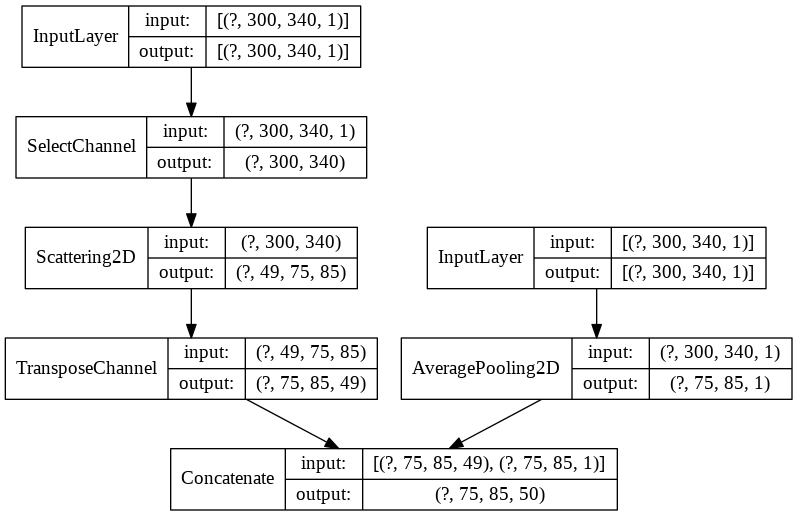

In [21]:
# In[9]

# ### MODEL GRAPH
from tensorflow.keras.utils import plot_model
plot_model(wst_model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_wst_architecture.png') 

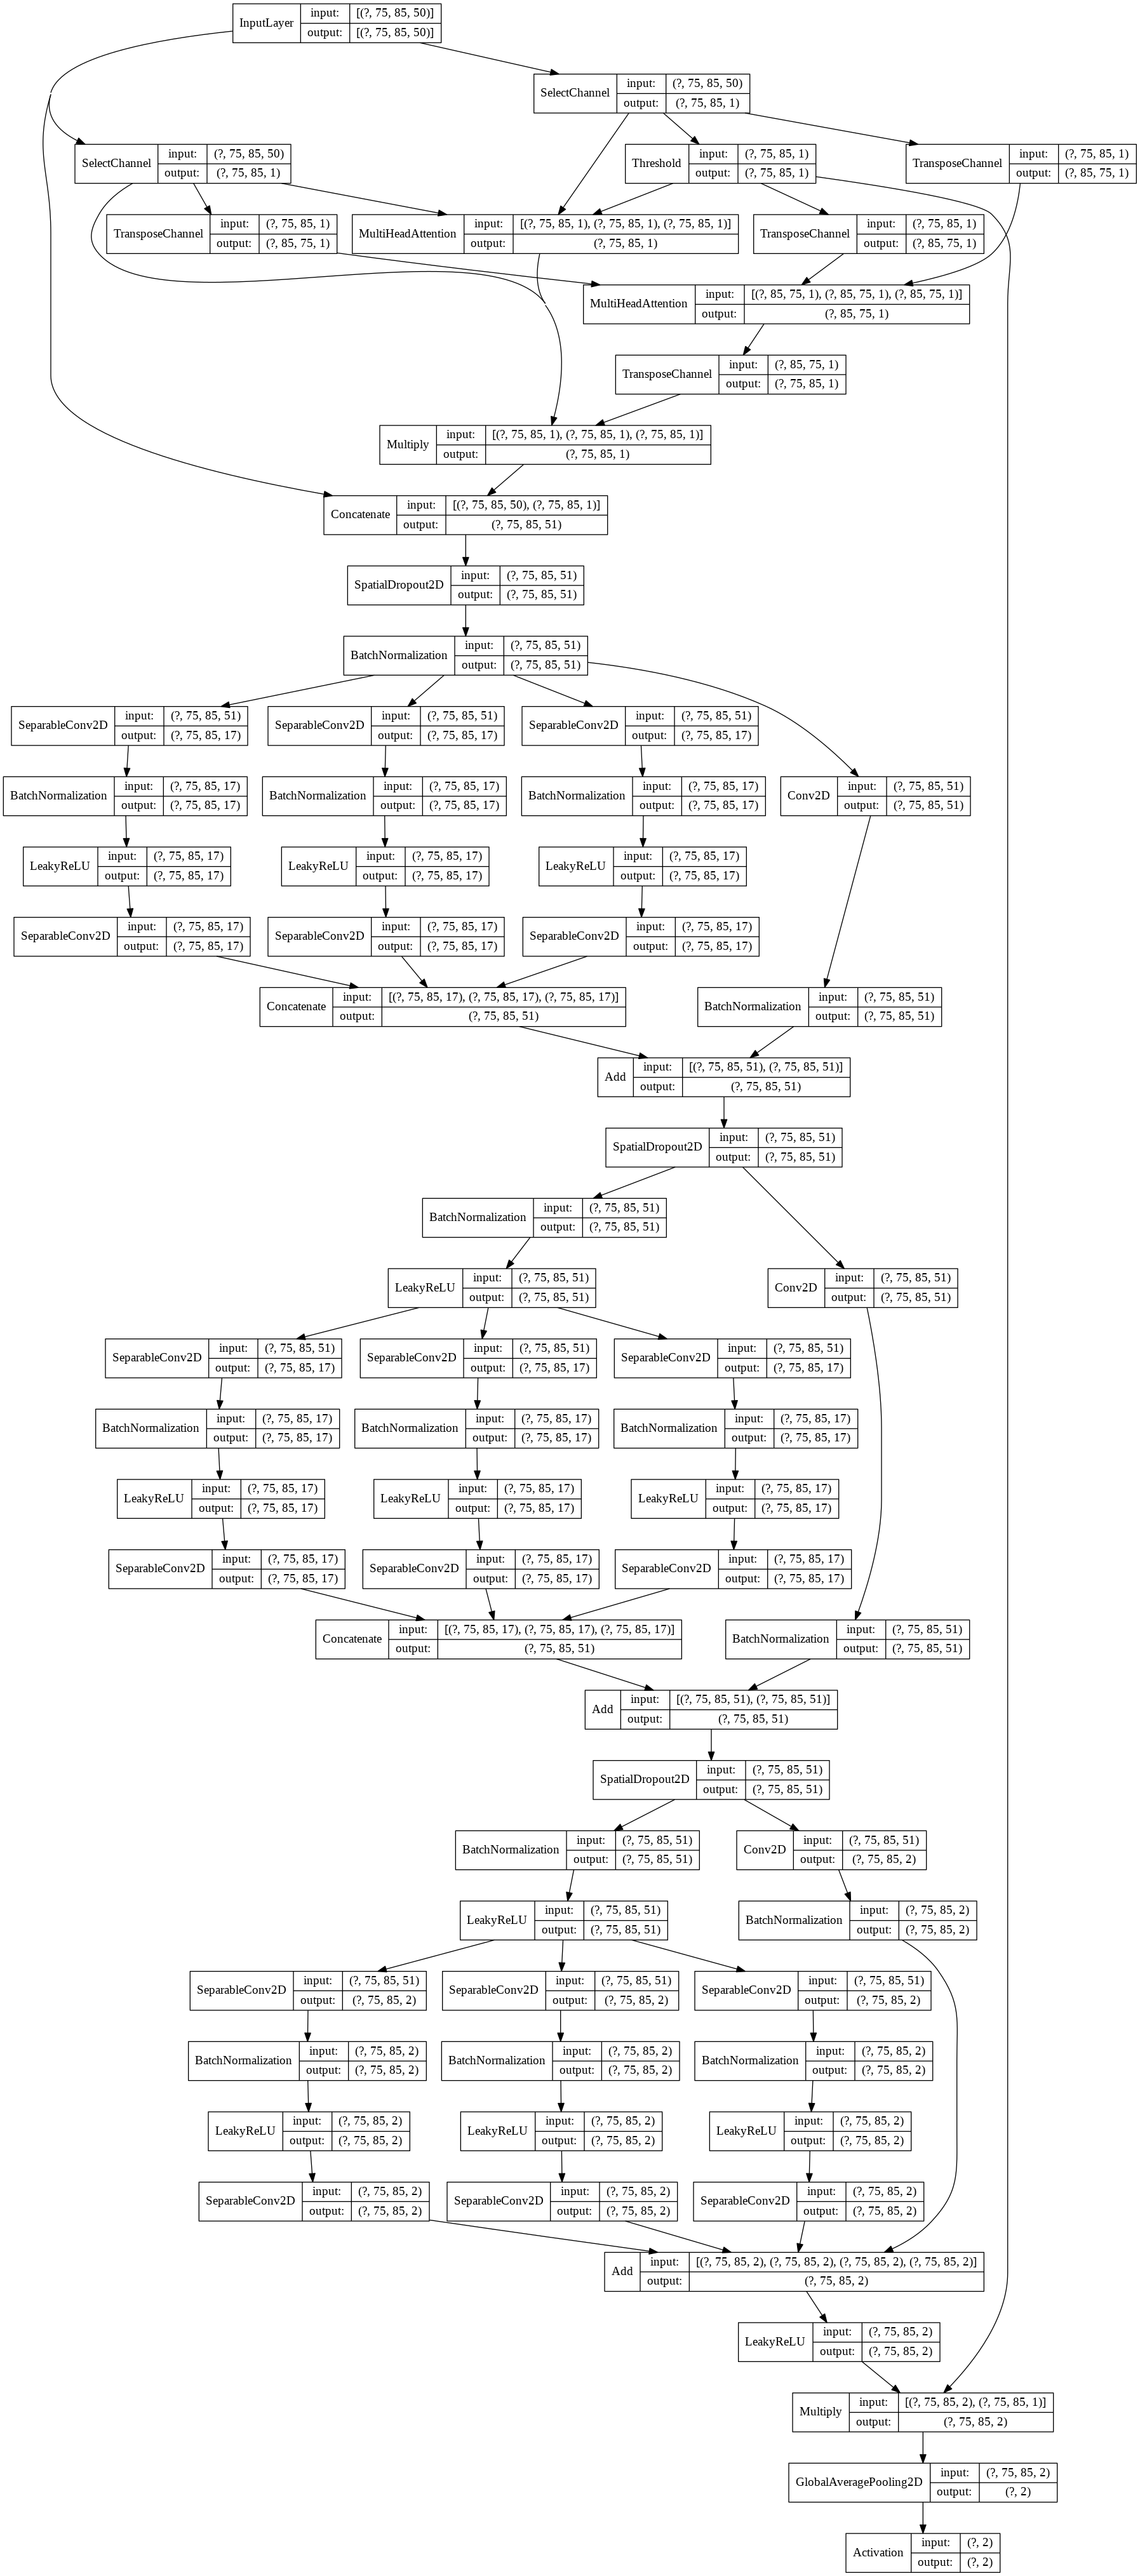

In [22]:
plot_model(resnet_model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_resnet_architecture.png')     

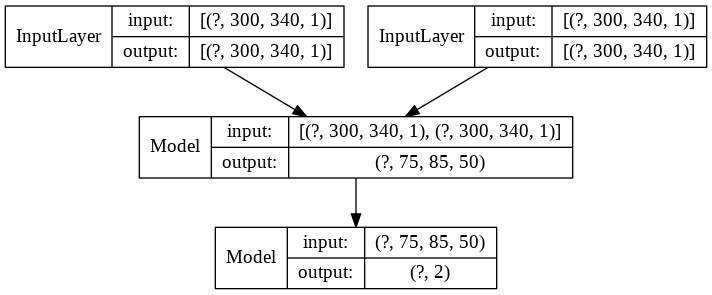

In [23]:
plot_model(model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_wst_resnet_architecture.png')

In [24]:
# In[10]:

# ### CALLBACKS
# %load_ext tensorboard
              
# Quiery the current directory
pwd = os.getcwd()

# Choose which model to save
save_best=True

if save_best:
    savefilepath='models/best_' + model_selection + '_' + model_number + '_weights.h5'
    # savefilepath='models/best_' + model_selection + '_' + model_number.h5'    
else:
    savefilepath='models/last_' + model_selection + '_' + model_number + '_weights.h5'
    # savefilepath='models/last_' + model_selection + '_' + model_number.h5'    

# Set the log directory
logs_base_dir = pwd + '/log_dir_2'
print(logs_base_dir)
os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

# Callback list
callbacks_list = [
# callback for logging the history
    tf.keras.callbacks.CSVLogger('models/' + model_selection + \
        '_' + model_number + '_history.csv', append=True),
            
# callback for tensorboard: launch from a different venv (not ipython) console as 
# 'tensorboard --logdir log_dir'
    tf.keras.callbacks.TensorBoard( 
        log_dir=logs_base_dir,
        histogram_freq=0, 
        write_graph=True, 
        write_images=True,
        profile_batch=0),
    
# callback for early stopping     
    tf.keras.callbacks.EarlyStopping( 
        monitor='val_loss',
#         monitor='val_categorical_accuracy',
        patience=2000, 
#         verbose=1, 
        min_delta = 0.001,
        mode='min',
#         mode='max',
        ),

# callback to save best model (here we save only the weights because the 
# dice coef loss is not stored in the model)    
    tf.keras.callbacks.ModelCheckpoint( 
        filepath=savefilepath,  
        monitor='val_loss', 
        save_best_only=save_best,      
        mode = 'min', 
        # verbose = 1,
        save_weights_only = True)]
   

/wsu/home/aa/aa14/aa1426/Documents/JENA/MYOTUBES_SEGMENTATION/Res-CRX-Net/log_dir_2


In [25]:
# In[11]:

# For JMS database
# H5_IMAGE_DIR = "dataset/COVID_standardized_pos4_neg5_image_expand_float_952_3_threshold_H5_CLASSWEIGHT/"

# For V7 database 
H5_IMAGE_DIR = "dataset/COVID_standardized_pos4_neg5_image_expand_float_6395_1_threshold_H5_CLASSWEIGHT/"

print(H5_IMAGE_DIR)


dataset/COVID_standardized_pos4_neg5_image_expand_float_6395_1_threshold_H5_CLASSWEIGHT/


In [26]:
# In[11]: 

# ### GENERATORS (simple K-fold or stratified by positive and negative classes)

# Get generators for training and validation sets. Set standard=False if the images were 
# already standardized or no standardization is needed.

NSPLITS = 6

datadir = H5_IMAGE_DIR

with open(datadir + "pos4_neg5_datasets_CLASSWEIGHT_only.json") as json_file:
    dataset = json.load(json_file)

train_h5 = dataset['train']

# Get class information
train_df = pd.read_csv("selected_train_020521_index.csv",index_col = 0)

# Add zeros to the y_true array if some image names were repeated at the end of the dictionary to 
# optimize the batch size
train_y = train_df['Positive'].tolist()
train_y = train_y + [0,0]

# Get unique patients information
patient_list = []
for patient in train_h5:
    patient_list.append(patient[:6])
    
unique_patients = np.unique(patient_list)

groups = []
for patient in patient_list:
    for ind,group in enumerate(unique_patients):
        if group == patient:
            groups.append(ind)
              

np.random.seed(1338)

perm_ind = np.random.permutation(np.arange(len(train_h5)))
train_h5_perm = np.array(train_h5)[np.uint32(perm_ind)]
train_y_perm = np.array(train_y)[np.uint32(perm_ind)]
groups_perm = np.array(groups)[np.uint32(perm_ind)]

print(train_h5_perm[:20])
print(train_y_perm[:20])

if KFOLD == 'Simple':    
    kf = KFold(n_splits=NSPLITS, random_state=20, shuffle=True)
    kf_split = kf.split(train_h5_perm)

elif KFOLD == 'Strati':    
    kf = StratifiedKFold(n_splits=NSPLITS, random_state=20, shuffle=True)
    kf_split = kf.split(train_h5_perm,train_y_perm)       
            
elif KFOLD == 'Group':    
    kf = GroupKFold(n_splits=NSPLITS)
    kf_split = kf.split(train_h5_perm,train_y_perm,groups_perm)

for i,[train_index, valid_index] in enumerate(kf_split):
    print("CYCLE",i,"TRAIN:", train_index[:10], "VALID:", valid_index[:10])
    print(len(train_index),len(valid_index))

    train_set = train_h5_perm[train_index]
    valid_set = train_h5_perm[valid_index]
    train_y = train_y_perm[train_index]
    valid_y = train_y_perm[valid_index]
    print(np.sum(train_y),np.sum(valid_y))        
    
PERM_TRAIN_SIZE = 13
PERM_VALID_SIZE = 13

print(PERM_TRAIN_SIZE,VAL_SIZE)
print(PERM_TRAIN_SIZE,PERM_VALID_SIZE)


['504662-001-3.h5' '002674-032-1.h5' '002216-009-1.h5' '002651-005-1.h5'
 '002252-009-1.h5' '002759-008-1.h5' '504242-001-1.h5' '505052-001-1.h5'
 '504200-001-2.h5' '002336-004-1.h5' '503668-001-1.h5' '504752-001-1.h5'
 '504266-001-2.h5' '503568-001-1.h5' '505145-001-1.h5' '504918-001-1.h5'
 '002496-011-4.h5' '503452-001-1.h5' '002158-004-1.h5' '504279-001-1.h5']
[0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0]
CYCLE 0 TRAIN: [ 0  1  2  3  4  5  7  8  9 10] VALID: [ 6 17 18 20 32 44 45 52 56 65]
1887 378
710 138
CYCLE 1 TRAIN: [ 0  1  2  3  4  5  6  7 10 11] VALID: [ 8  9 12 13 14 16 19 33 40 53]
1887 378
704 144
CYCLE 2 TRAIN: [ 0  1  2  3  5  6  7  8  9 11] VALID: [ 4 10 21 22 24 35 36 41 42 54]
1887 378
701 147
CYCLE 3 TRAIN: [ 2  3  4  5  6  8  9 10 11 12] VALID: [ 0  1  7 23 29 31 34 46 50 70]
1888 377
710 138
CYCLE 4 TRAIN: [ 0  1  4  5  6  7  8  9 10 11] VALID: [ 2  3 15 25 26 30 37 38 49 57]
1888 377
697 151
CYCLE 5 TRAIN: [ 0  1  2  3  4  6  7  8  9 10] VALID: [ 5 11 27 28 39 43 47 4

In [27]:
# In[12]:

# ### Function for plotting stratification

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


[0. 0. 0. ... 0. 0. 0.]


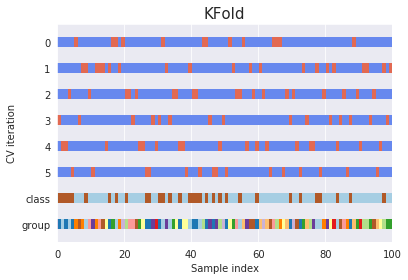

In [28]:
# In[13]:

# ### Plot the K-fold  

# If only one group
groups = np.zeros(len(train_y_perm))
print(groups)

from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots()
plot_cv_indices(kf, train_h5_perm, train_y_perm, groups_perm, ax, NSPLITS)


In [29]:
# In[14]:

CROSS_VAL = True

if CROSS_VAL:
    train_generator = DataGenerator(train_set, datadir, augment=True, shuffle=True, standard=False,\
                                          batch_size=PERM_TRAIN_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS),\
                                          mask_dim=(HEIGHT, WIDTH, 1),\
                                          mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)
    valid_generator = DataGenerator(valid_set, datadir, augment=True, shuffle=True, standard=False,\
                                          batch_size=PERM_VALID_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS),\
                                          mask_dim=(HEIGHT, WIDTH, 1),\
                                          mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)      
else:                                                                         
    train_generator = DataGenerator(dataset["train"], datadir, augment=True, shuffle=True, standard=False,\
                                          batch_size=TRAIN_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS),\
                                          mask_dim=(HEIGHT, WIDTH, 1),\
                                          mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)
    valid_generator = DataGenerator(dataset["valid"], datadir, augment=True, shuffle=True, standard=False,\
                                          batch_size=TRAIN_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS),\
                                          mask_dim=(HEIGHT, WIDTH, 1),\
                                          mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)

# ### GENERATORS CHECKS

print(len(dataset["train"]),len(dataset["valid"]))
print(TRAIN_SIZE,VAL_SIZE)
print(PERM_TRAIN_SIZE,PERM_VALID_SIZE)
print(len(train_generator),len(valid_generator))

x_m, y, w = train_generator.__getitem__(0)

print(x_m[0].shape)

2265 1532
15 15
13 13
145 29
(13, 300, 340, 1)


In [30]:
wst = att_model(x_m)
print(wst.shape)

(13, 75, 85, 51)


In [ ]:
plt.imshow(wst[0,:,:,0], cmap="gray");

In [ ]:
plt.imshow(wst[0,:,:,49], cmap="gray");

In [ ]:
plt.imshow(wst[0,:,:,50], cmap="gray");

In [ ]:
plt.imshow(wst[0,:,:,0]*wst[0,:,:,49], cmap="gray");

In [ ]:

img_list = list(range(49)) + [50] 
plt.figure(figsize=(18,32.5))
img_num = 6
i = 0

for num in img_list:    
    i += 1    
    plt.subplot(10,5,i)
    plt.axis('off')    

    wst_img = wst[img_num,:,:,num]
    plt.imshow(wst_img, cmap='gray')
    plt.tight_layout()
    

In [36]:
wst = wst_model(x_m)
print(wst.shape)

(13, 75, 85, 50)


In [ ]:
plt.imshow(wst[img_num,:,:,0], cmap="gray");

In [ ]:
plt.imshow(wst[img_num,:,:,49], cmap="gray");

In [ ]:
plt.imshow(x_m[0][img_num,:,:,0], cmap="gray");

In [ ]:
plt.imshow(x_m[1][img_num,:,:,0], cmap="gray");

In [ ]:
plt.figure(figsize=(18,32.5))
img_num = 6
i = 0

for num in range(50):
    i += 1    
    plt.subplot(10,5,i)
    plt.axis('off')    

    wst_img = wst[img_num,:,:,num]
    plt.imshow(wst_img, cmap='gray')
    plt.tight_layout()
    

In [43]:
### In[15]:

# ### TRAINING
n_outputs = 1
fit_cycles = NSPLITS
queue_size = 15
initial_epoch = 0  
epoch_num = 200
train_steps = len(train_generator)
val_steps = len(valid_generator)
n_workers=1

print(f"Train steps = {train_steps}, Valid steps = {val_steps}")

K.clear_session()
del model

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    wst_model = WaveletScatteringTransform(input_shape=(HEIGHT, WIDTH, CHANNELS),
                                           upsample=UPSAMPLE,
                                           upsample_kernel=UPSAMPLE_KERNEL)

    resnet_model_0 = ResNet(input_shape_1=(RESNET_DIM_1, RESNET_DIM_2, WSTCHANNELS),
                           input_shape_2=(RESNET_DIM_1, RESNET_DIM_2, 1), 
                           num_class=NUM_CLASS,
                           ks1=KS1, ks2=KS2, ks3=KS3, 
                           dl1=DL1, dl2=DL2, dl3=DL3,
                           filters=NF,resblock1=NR1,
                           r_filters=NFL, resblock2=NR2,
                           dil_mode=DIL_MODE, 
                           sp_dropout=DR1,re_dropout=DR2,
                           prep=PREP,
                           stem=STEM,
                           mask_float=MSK_FLOAT,
                           mask_threshold=MSK_THRESHOLD,
                           att=ATT,
                           head_size=HEAD_SIZE,
                           num_heads=NUM_HEAD,
                           value_att=VALUE_ATT,
                           scale_by_input=SCALE_BY_INPUT,
                           scale_threshold=SCALE_THRESHOLD,
                           scale_to_span=SCALE_TO_SPAN,
                           span=SPAN,                            
                           blur_sbi=BLUR_SBI,
                           blur_sbi_std=BLUR_SBI_STD,                                                                 
                           return_seq=True)
                 
    resnet_model_0.save_weights('models/' + model_selection + '_' + model_number + '_resnet_model_0' + '_weights' + '.h5')


    if KFOLD == 'Simple':
        kf = KFold(n_splits=NSPLITS, random_state=20, shuffle=True)
        kf_split = kf.split(train_h5_perm)
    elif KFOLD == 'Strati':
        kf = StratifiedKFold(n_splits=NSPLITS, random_state=20, shuffle=True)
        kf_split = kf.split(train_h5_perm,train_y_perm)        
    elif KFOLD == 'Group':
        kf = GroupKFold(n_splits=NSPLITS)
        kf_split = kf.split(train_h5_perm,train_y_perm,groups_perm)

    
    for i,[train_index, valid_index] in enumerate(kf_split):

        print("CYCLE",i,"TRAIN:", train_index[:10], "VALID:", valid_index[:10])
        print(len(train_index),len(valid_index))        

        train_set = train_h5_perm[train_index]
        valid_set = train_h5_perm[valid_index]
        train_y = train_y_perm[train_index]
        valid_y = train_y_perm[valid_index]
        print(np.sum(train_y),np.sum(valid_y))          

        # Reinitialize the generators and store the permuted lists
        train_set = train_h5_perm[train_index]
        valid_set = train_h5_perm[valid_index]        
        train_y = train_y_perm[train_index]
        valid_y = train_y_perm[valid_index]
        print(f"Total training samples: {len(train_set)} , Total validation samples: {len(valid_set)}")        
        print(f"Positive training samples: {np.sum(train_y)} , Positive validation samples: {np.sum(valid_y)}")         

        train_set_dict = {"train":train_set.tolist()}          
        with open('models/' + model_selection + '_' + model_number + '_M' + str(i) + "_train_set.json", 'w') as filehandle:
            json.dump(train_set_dict, filehandle)
        valid_set_dict = {"valid":valid_set.tolist()}          
        with open('models/' + model_selection + '_' + model_number + '_M' + str(i) + "_valid_set.json", 'w') as filehandle:
            json.dump(valid_set_dict, filehandle)          

        train_generator = DataGenerator(train_set, datadir, augment=True, shuffle=True, standard=False,\
                                              batch_size=PERM_TRAIN_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS), \
                                              mask_dim=(HEIGHT, WIDTH, 1), \
                                              mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, \
                                              verbose=0)
        valid_generator = DataGenerator(valid_set, datadir, augment=True, shuffle=True, standard=False,\
                                              batch_size=PERM_VALID_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS), \
                                              mask_dim=(HEIGHT, WIDTH, 1), \
                                              mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, \
                                              verbose=0)                 
        
        wst_input_1 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
        wst_input_2 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
        wst_output_1 = wst_model([wst_input_1,wst_input_2])
        resnet_model = clone_model(resnet_model_0)
        resnet_model.load_weights('models/' + model_selection + '_' + model_number + '_resnet_model_0' + '_weights' + '.h5')
        resnet_output = resnet_model(wst_output_1)
        model = Model([wst_input_1,wst_input_2], resnet_output,name='wst_resnet')
        
        model.compile(optimizer=OPTIMIZER, 
                      loss=tf.keras.losses.CategoricalCrossentropy(), 
                      metrics=[tf.keras.metrics.CategoricalAccuracy()])                       

        history = model.fit(train_generator, 
                            validation_data=valid_generator,
                            steps_per_epoch=train_steps,
                            validation_steps=val_steps,
                            epochs=epoch_num,
                            initial_epoch=initial_epoch,
                            max_queue_size =queue_size,
                            workers=n_workers,
                            callbacks = callbacks_list)
        
        resnet_model.save('models/' + model_selection + '_' + model_number + '_M' + str(i) +  '_resnet_all' + '.h5',
                overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)               
        resnet_model.save_weights('models/' + model_selection + '_' + model_number + '_M' + str(i) + '_resnet_weights' + '.h5')        

        del model
        

Train steps = 145, Valid steps = 29
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
CYCLE 0 TRAIN: [ 0  1  2  3  4  5  7  8  9 10] VALID: [ 6 17 18 20 32 44 45 52 56 65]
1887 378
710 138
Total training samples: 1887 , Total validation samples: 378
Positive training samples: 710 , Positive validation samples: 138
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 145 steps, validate for 29 steps
Epoch 1/200
INFO:tensorflow:batch_all_reduce: 100 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 100 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
145/145 [==============================] - 232s 2s/step - loss: 0.3212 - categorical_accuracy: 0.5639 - val_loss: 0.3242 - val_categorical_accuracy: 0.4085
Epoch 2/200
145/14

Epoch 43/200
145/145 [==============================] - 60s 414ms/step - loss: 0.2319 - categorical_accuracy: 0.7629 - val_loss: 0.2602 - val_categorical_accuracy: 0.6472
Epoch 44/200
145/145 [==============================] - 60s 413ms/step - loss: 0.2227 - categorical_accuracy: 0.7613 - val_loss: 0.2121 - val_categorical_accuracy: 0.7798
Epoch 45/200
145/145 [==============================] - 65s 452ms/step - loss: 0.2253 - categorical_accuracy: 0.7655 - val_loss: 0.2618 - val_categorical_accuracy: 0.6313
Epoch 46/200
145/145 [==============================] - 56s 385ms/step - loss: 0.2299 - categorical_accuracy: 0.7650 - val_loss: 0.2178 - val_categorical_accuracy: 0.7692
Epoch 47/200
145/145 [==============================] - 60s 414ms/step - loss: 0.2242 - categorical_accuracy: 0.7655 - val_loss: 0.2213 - val_categorical_accuracy: 0.7560
Epoch 48/200
145/145 [==============================] - 56s 386ms/step - loss: 0.2266 - categorical_accuracy: 0.7618 - val_loss: 0.2226 - val_cat

Epoch 91/200
145/145 [==============================] - 64s 444ms/step - loss: 0.1969 - categorical_accuracy: 0.8016 - val_loss: 0.2004 - val_categorical_accuracy: 0.7984
Epoch 92/200
145/145 [==============================] - 56s 387ms/step - loss: 0.1953 - categorical_accuracy: 0.8048 - val_loss: 0.2003 - val_categorical_accuracy: 0.7984
Epoch 93/200
145/145 [==============================] - 61s 418ms/step - loss: 0.1977 - categorical_accuracy: 0.8053 - val_loss: 0.2047 - val_categorical_accuracy: 0.7905
Epoch 94/200
145/145 [==============================] - 60s 412ms/step - loss: 0.1950 - categorical_accuracy: 0.8037 - val_loss: 0.1947 - val_categorical_accuracy: 0.7878
Epoch 95/200
145/145 [==============================] - 56s 386ms/step - loss: 0.1921 - categorical_accuracy: 0.8005 - val_loss: 0.2044 - val_categorical_accuracy: 0.7825
Epoch 96/200
145/145 [==============================] - 62s 424ms/step - loss: 0.1852 - categorical_accuracy: 0.8191 - val_loss: 0.2399 - val_cat

Epoch 139/200
145/145 [==============================] - 59s 408ms/step - loss: 0.1699 - categorical_accuracy: 0.8334 - val_loss: 0.2436 - val_categorical_accuracy: 0.8143
Epoch 140/200
145/145 [==============================] - 59s 405ms/step - loss: 0.1712 - categorical_accuracy: 0.8313 - val_loss: 0.1986 - val_categorical_accuracy: 0.7878
Epoch 141/200
145/145 [==============================] - 59s 406ms/step - loss: 0.1752 - categorical_accuracy: 0.8292 - val_loss: 0.2200 - val_categorical_accuracy: 0.7613
Epoch 142/200
145/145 [==============================] - 59s 408ms/step - loss: 0.1694 - categorical_accuracy: 0.8297 - val_loss: 0.1914 - val_categorical_accuracy: 0.8117
Epoch 143/200
145/145 [==============================] - 59s 409ms/step - loss: 0.1757 - categorical_accuracy: 0.8249 - val_loss: 0.1982 - val_categorical_accuracy: 0.7666
Epoch 144/200
145/145 [==============================] - 59s 406ms/step - loss: 0.1709 - categorical_accuracy: 0.8276 - val_loss: 0.2333 - v

Epoch 29/200
145/145 [==============================] - 63s 431ms/step - loss: 0.2580 - categorical_accuracy: 0.7056 - val_loss: 0.2629 - val_categorical_accuracy: 0.6340
Epoch 30/200
145/145 [==============================] - 56s 385ms/step - loss: 0.2544 - categorical_accuracy: 0.6976 - val_loss: 0.2513 - val_categorical_accuracy: 0.7188
Epoch 31/200
145/145 [==============================] - 61s 423ms/step - loss: 0.2507 - categorical_accuracy: 0.7156 - val_loss: 0.2457 - val_categorical_accuracy: 0.7162
Epoch 32/200
145/145 [==============================] - 65s 448ms/step - loss: 0.2513 - categorical_accuracy: 0.7135 - val_loss: 0.2485 - val_categorical_accuracy: 0.7215
Epoch 33/200
145/145 [==============================] - 56s 386ms/step - loss: 0.2515 - categorical_accuracy: 0.7135 - val_loss: 0.2435 - val_categorical_accuracy: 0.7321
Epoch 34/200
145/145 [==============================] - 56s 385ms/step - loss: 0.2457 - categorical_accuracy: 0.7172 - val_loss: 0.2441 - val_cat

Epoch 77/200
145/145 [==============================] - 60s 417ms/step - loss: 0.2092 - categorical_accuracy: 0.7830 - val_loss: 0.2160 - val_categorical_accuracy: 0.7692
Epoch 78/200
145/145 [==============================] - 65s 451ms/step - loss: 0.2044 - categorical_accuracy: 0.7958 - val_loss: 0.2143 - val_categorical_accuracy: 0.8117
Epoch 79/200
145/145 [==============================] - 56s 388ms/step - loss: 0.2022 - categorical_accuracy: 0.8005 - val_loss: 0.2153 - val_categorical_accuracy: 0.7692
Epoch 80/200
145/145 [==============================] - 56s 386ms/step - loss: 0.2069 - categorical_accuracy: 0.7905 - val_loss: 0.2194 - val_categorical_accuracy: 0.7480
Epoch 81/200
145/145 [==============================] - 63s 437ms/step - loss: 0.2086 - categorical_accuracy: 0.7920 - val_loss: 0.2224 - val_categorical_accuracy: 0.8011
Epoch 82/200
145/145 [==============================] - 60s 415ms/step - loss: 0.2073 - categorical_accuracy: 0.7973 - val_loss: 0.2200 - val_cat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145/145 [==============================] - 60s 416ms/step - loss: 0.1874 - categorical_accuracy: 0.8117 - val_loss: 0.1927 - val_categorical_accuracy: 0.8064
Epoch 128/200
145/145 [==============================] - 61s 423ms/step - loss: 0.1826 - categorical_accuracy: 0.8170 - val_loss: 0.2226 - val_categorical_accuracy: 0.7905
Epoch 129/200
145/145 [==============================] - 61s 420ms/step - loss: 0.1775 - categorical_accuracy: 0.8223 - val_loss: 0.2213 - val_categorical_accuracy: 0.8011
Epoch 130/200
145/145 [==============================] - 56s 385ms/step - loss: 0.1811 - categorical_accuracy: 0.8218 - val_loss: 0.2111 - val_categorical_accuracy: 0.7931
Epoch 131/200
145/145 [==============================] - 55s 378ms/step - loss: 0.1818 - categorical_accuracy: 0.8149 - val_loss: 0.2074 - val_categorical_accuracy: 0.8011
Epoch 132/200
145/145 [==============================] - 67s 462ms/step - loss: 0.1818 - categorical_accuracy: 0.8233 - val_loss: 0.2054 - val_categorical

Epoch 175/200
145/145 [==============================] - 59s 409ms/step - loss: 0.1699 - categorical_accuracy: 0.8382 - val_loss: 0.2163 - val_categorical_accuracy: 0.7692
Epoch 176/200
145/145 [==============================] - 56s 384ms/step - loss: 0.1707 - categorical_accuracy: 0.8297 - val_loss: 0.2069 - val_categorical_accuracy: 0.8090
Epoch 177/200
145/145 [==============================] - 56s 386ms/step - loss: 0.1693 - categorical_accuracy: 0.8302 - val_loss: 0.2306 - val_categorical_accuracy: 0.7878
Epoch 178/200
145/145 [==============================] - 63s 438ms/step - loss: 0.1615 - categorical_accuracy: 0.8456 - val_loss: 0.2354 - val_categorical_accuracy: 0.8196
Epoch 179/200
145/145 [==============================] - 58s 398ms/step - loss: 0.1600 - categorical_accuracy: 0.8387 - val_loss: 0.2079 - val_categorical_accuracy: 0.7931
Epoch 180/200
145/145 [==============================] - 56s 386ms/step - loss: 0.1602 - categorical_accuracy: 0.8472 - val_loss: 0.2074 - v

Epoch 18/200
145/145 [==============================] - 63s 434ms/step - loss: 0.2782 - categorical_accuracy: 0.6700 - val_loss: 0.2746 - val_categorical_accuracy: 0.6393
Epoch 19/200
145/145 [==============================] - 58s 399ms/step - loss: 0.2805 - categorical_accuracy: 0.6737 - val_loss: 0.2717 - val_categorical_accuracy: 0.6711
Epoch 20/200
145/145 [==============================] - 56s 384ms/step - loss: 0.2769 - categorical_accuracy: 0.6658 - val_loss: 0.3068 - val_categorical_accuracy: 0.6923
Epoch 21/200
145/145 [==============================] - 60s 413ms/step - loss: 0.2720 - categorical_accuracy: 0.6621 - val_loss: 0.2670 - val_categorical_accuracy: 0.6286
Epoch 22/200
145/145 [==============================] - 56s 383ms/step - loss: 0.2687 - categorical_accuracy: 0.6849 - val_loss: 0.3487 - val_categorical_accuracy: 0.6897
Epoch 23/200
145/145 [==============================] - 60s 416ms/step - loss: 0.2705 - categorical_accuracy: 0.6727 - val_loss: 0.2703 - val_cat

Epoch 66/200
145/145 [==============================] - 58s 397ms/step - loss: 0.2234 - categorical_accuracy: 0.7607 - val_loss: 0.2515 - val_categorical_accuracy: 0.7931
Epoch 67/200
145/145 [==============================] - 57s 393ms/step - loss: 0.2230 - categorical_accuracy: 0.7645 - val_loss: 0.2422 - val_categorical_accuracy: 0.6817
Epoch 68/200
145/145 [==============================] - 56s 389ms/step - loss: 0.2173 - categorical_accuracy: 0.7745 - val_loss: 0.2319 - val_categorical_accuracy: 0.7454
Epoch 69/200
145/145 [==============================] - 57s 392ms/step - loss: 0.2234 - categorical_accuracy: 0.7729 - val_loss: 0.2217 - val_categorical_accuracy: 0.7719
Epoch 70/200
145/145 [==============================] - 77s 531ms/step - loss: 0.2194 - categorical_accuracy: 0.7676 - val_loss: 0.2323 - val_categorical_accuracy: 0.8090
Epoch 71/200
145/145 [==============================] - 58s 399ms/step - loss: 0.2193 - categorical_accuracy: 0.7756 - val_loss: 0.2276 - val_cat

Epoch 114/200
145/145 [==============================] - 56s 389ms/step - loss: 0.2024 - categorical_accuracy: 0.7867 - val_loss: 0.2431 - val_categorical_accuracy: 0.7241
Epoch 115/200
145/145 [==============================] - 57s 392ms/step - loss: 0.1931 - categorical_accuracy: 0.8032 - val_loss: 0.2375 - val_categorical_accuracy: 0.7825
Epoch 116/200
145/145 [==============================] - 60s 411ms/step - loss: 0.1924 - categorical_accuracy: 0.8048 - val_loss: 0.2104 - val_categorical_accuracy: 0.7984
Epoch 117/200
145/145 [==============================] - 58s 400ms/step - loss: 0.1958 - categorical_accuracy: 0.7995 - val_loss: 0.2089 - val_categorical_accuracy: 0.7825
Epoch 118/200
145/145 [==============================] - 57s 393ms/step - loss: 0.1915 - categorical_accuracy: 0.8069 - val_loss: 0.2143 - val_categorical_accuracy: 0.7878
Epoch 119/200
145/145 [==============================] - 57s 390ms/step - loss: 0.1897 - categorical_accuracy: 0.8058 - val_loss: 0.2226 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145/145 [==============================] - 57s 390ms/step - loss: 0.1677 - categorical_accuracy: 0.8387 - val_loss: 0.2029 - val_categorical_accuracy: 0.8302
Epoch 189/200
145/145 [==============================] - 59s 409ms/step - loss: 0.1575 - categorical_accuracy: 0.8493 - val_loss: 0.2849 - val_categorical_accuracy: 0.7798
Epoch 190/200
145/145 [==============================] - 57s 390ms/step - loss: 0.1645 - categorical_accuracy: 0.8440 - val_loss: 0.2313 - val_categorical_accuracy: 0.7931
Epoch 191/200
145/145 [==============================] - 58s 400ms/step - loss: 0.1621 - categorical_accuracy: 0.8477 - val_loss: 0.2203 - val_categorical_accuracy: 0.7798
Epoch 192/200
145/145 [==============================] - 57s 391ms/step - loss: 0.1651 - categorical_accuracy: 0.8403 - val_loss: 0.2203 - val_categorical_accuracy: 0.7560
Epoch 193/200
145/145 [==============================] - 56s 388ms/step - loss: 0.1597 - categorical_accuracy: 0.8403 - val_loss: 0.1957 - val_categorical

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145/145 [==============================] - 59s 405ms/step - loss: 0.2554 - categorical_accuracy: 0.7040 - val_loss: 0.2574 - val_categorical_accuracy: 0.7082
Epoch 31/200
145/145 [==============================] - 57s 392ms/step - loss: 0.2499 - categorical_accuracy: 0.7061 - val_loss: 0.2723 - val_categorical_accuracy: 0.6764
Epoch 32/200
145/145 [==============================] - 58s 400ms/step - loss: 0.2525 - categorical_accuracy: 0.7156 - val_loss: 0.2747 - val_categorical_accuracy: 0.6472
Epoch 33/200
145/145 [==============================] - 56s 388ms/step - loss: 0.2455 - categorical_accuracy: 0.7257 - val_loss: 0.2747 - val_categorical_accuracy: 0.6658
Epoch 34/200
145/145 [==============================] - 56s 389ms/step - loss: 0.2510 - categorical_accuracy: 0.7225 - val_loss: 0.2634 - val_categorical_accuracy: 0.7056
Epoch 35/200
145/145 [==============================] - 59s 408ms/step - loss: 0.2482 - categorical_accuracy: 0.7204 - val_loss: 0.2656 - val_categorical_accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145/145 [==============================] - 57s 391ms/step - loss: 0.2121 - categorical_accuracy: 0.7820 - val_loss: 0.2372 - val_categorical_accuracy: 0.7321
Epoch 70/200
145/145 [==============================] - 57s 391ms/step - loss: 0.2090 - categorical_accuracy: 0.7878 - val_loss: 0.2402 - val_categorical_accuracy: 0.7374
Epoch 71/200
145/145 [==============================] - 59s 408ms/step - loss: 0.2122 - categorical_accuracy: 0.7767 - val_loss: 0.2549 - val_categorical_accuracy: 0.7162
Epoch 72/200
145/145 [==============================] - 58s 401ms/step - loss: 0.2162 - categorical_accuracy: 0.7772 - val_loss: 0.2443 - val_categorical_accuracy: 0.7427
Epoch 73/200
145/145 [==============================] - 57s 392ms/step - loss: 0.2085 - categorical_accuracy: 0.7894 - val_loss: 0.2467 - val_categorical_accuracy: 0.7454
Epoch 74/200
145/145 [==============================] - 57s 392ms/step - loss: 0.2059 - categorical_accuracy: 0.7963 - val_loss: 0.2622 - val_categorical_accu

Epoch 117/200
145/145 [==============================] - 58s 400ms/step - loss: 0.1788 - categorical_accuracy: 0.8297 - val_loss: 0.2351 - val_categorical_accuracy: 0.7798
Epoch 118/200
145/145 [==============================] - 58s 399ms/step - loss: 0.1779 - categorical_accuracy: 0.8313 - val_loss: 0.2438 - val_categorical_accuracy: 0.7613
Epoch 119/200
145/145 [==============================] - 58s 401ms/step - loss: 0.1851 - categorical_accuracy: 0.8191 - val_loss: 0.2427 - val_categorical_accuracy: 0.7056
Epoch 120/200
145/145 [==============================] - 57s 391ms/step - loss: 0.1864 - categorical_accuracy: 0.8122 - val_loss: 0.2355 - val_categorical_accuracy: 0.7692
Epoch 121/200
145/145 [==============================] - 57s 391ms/step - loss: 0.1795 - categorical_accuracy: 0.8239 - val_loss: 0.2726 - val_categorical_accuracy: 0.7613
Epoch 122/200
145/145 [==============================] - 56s 389ms/step - loss: 0.1816 - categorical_accuracy: 0.8265 - val_loss: 0.2412 - v

Epoch 7/200
145/145 [==============================] - 58s 401ms/step - loss: 0.2997 - categorical_accuracy: 0.6175 - val_loss: 0.2842 - val_categorical_accuracy: 0.6684
Epoch 8/200
145/145 [==============================] - 57s 392ms/step - loss: 0.2996 - categorical_accuracy: 0.6260 - val_loss: 0.2983 - val_categorical_accuracy: 0.6207
Epoch 9/200
145/145 [==============================] - 56s 389ms/step - loss: 0.2937 - categorical_accuracy: 0.6286 - val_loss: 0.3442 - val_categorical_accuracy: 0.6419
Epoch 10/200
145/145 [==============================] - 56s 390ms/step - loss: 0.2884 - categorical_accuracy: 0.6345 - val_loss: 0.2916 - val_categorical_accuracy: 0.6897
Epoch 11/200
145/145 [==============================] - 59s 409ms/step - loss: 0.2845 - categorical_accuracy: 0.6419 - val_loss: 0.2846 - val_categorical_accuracy: 0.6631
Epoch 12/200
145/145 [==============================] - 57s 390ms/step - loss: 0.2809 - categorical_accuracy: 0.6531 - val_loss: 0.2760 - val_catego

Epoch 55/200
145/145 [==============================] - 57s 391ms/step - loss: 0.2087 - categorical_accuracy: 0.7873 - val_loss: 0.2233 - val_categorical_accuracy: 0.7586
Epoch 56/200
145/145 [==============================] - 57s 392ms/step - loss: 0.1994 - categorical_accuracy: 0.7883 - val_loss: 0.2303 - val_categorical_accuracy: 0.7454
Epoch 57/200
145/145 [==============================] - 60s 413ms/step - loss: 0.2070 - categorical_accuracy: 0.7772 - val_loss: 0.2343 - val_categorical_accuracy: 0.7321
Epoch 58/200
145/145 [==============================] - 60s 412ms/step - loss: 0.2015 - categorical_accuracy: 0.7947 - val_loss: 0.2350 - val_categorical_accuracy: 0.7905
Epoch 59/200
145/145 [==============================] - 58s 401ms/step - loss: 0.2010 - categorical_accuracy: 0.7905 - val_loss: 0.2352 - val_categorical_accuracy: 0.7613
Epoch 60/200
145/145 [==============================] - 56s 387ms/step - loss: 0.1990 - categorical_accuracy: 0.7952 - val_loss: 0.2247 - val_cat

Epoch 103/200
145/145 [==============================] - 56s 388ms/step - loss: 0.1804 - categorical_accuracy: 0.8170 - val_loss: 0.2334 - val_categorical_accuracy: 0.7639
Epoch 104/200
145/145 [==============================] - 59s 410ms/step - loss: 0.1739 - categorical_accuracy: 0.8265 - val_loss: 0.2382 - val_categorical_accuracy: 0.7560
Epoch 105/200
145/145 [==============================] - 56s 389ms/step - loss: 0.1699 - categorical_accuracy: 0.8318 - val_loss: 0.2283 - val_categorical_accuracy: 0.7666
Epoch 106/200
145/145 [==============================] - 58s 401ms/step - loss: 0.1799 - categorical_accuracy: 0.8138 - val_loss: 0.2149 - val_categorical_accuracy: 0.7905
Epoch 107/200
145/145 [==============================] - 57s 392ms/step - loss: 0.1752 - categorical_accuracy: 0.8239 - val_loss: 0.2555 - val_categorical_accuracy: 0.7798
Epoch 108/200
145/145 [==============================] - 57s 390ms/step - loss: 0.1734 - categorical_accuracy: 0.8191 - val_loss: 0.2369 - v

Epoch 198/200
145/145 [==============================] - 58s 401ms/step - loss: 0.1389 - categorical_accuracy: 0.8668 - val_loss: 0.2463 - val_categorical_accuracy: 0.7666
Epoch 199/200
145/145 [==============================] - 56s 389ms/step - loss: 0.1485 - categorical_accuracy: 0.8568 - val_loss: 0.2252 - val_categorical_accuracy: 0.7692
Epoch 200/200
145/145 [==============================] - 56s 389ms/step - loss: 0.1417 - categorical_accuracy: 0.8674 - val_loss: 0.2159 - val_categorical_accuracy: 0.7851
CYCLE 5 TRAIN: [ 0  1  2  3  4  6  7  8  9 10] VALID: [ 5 11 27 28 39 43 47 48 51 64]
1888 377
718 130
Total training samples: 1888 , Total validation samples: 377
Positive training samples: 718 , Positive validation samples: 130
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 145 steps, validate for 29 steps
Epoch 1/200
145/145 [==============================] - 95s 652ms/step - loss: 0.3246 - categorical_accuracy: 0.5220 - val_loss: 0.3115 - val_categorical_accuracy

Epoch 90/200
145/145 [==============================] - 57s 390ms/step - loss: 0.2091 - categorical_accuracy: 0.7920 - val_loss: 0.2210 - val_categorical_accuracy: 0.7613
Epoch 91/200
145/145 [==============================] - 58s 402ms/step - loss: 0.2102 - categorical_accuracy: 0.7830 - val_loss: 0.2522 - val_categorical_accuracy: 0.7692
Epoch 92/200
145/145 [==============================] - 57s 390ms/step - loss: 0.2079 - categorical_accuracy: 0.7958 - val_loss: 0.2148 - val_categorical_accuracy: 0.7931
Epoch 93/200
145/145 [==============================] - 56s 389ms/step - loss: 0.2077 - categorical_accuracy: 0.7846 - val_loss: 0.2235 - val_categorical_accuracy: 0.7294
Epoch 94/200
145/145 [==============================] - 59s 410ms/step - loss: 0.2101 - categorical_accuracy: 0.7867 - val_loss: 0.2083 - val_categorical_accuracy: 0.7851
Epoch 95/200
145/145 [==============================] - 56s 389ms/step - loss: 0.2077 - categorical_accuracy: 0.7894 - val_loss: 0.2470 - val_cat

Epoch 138/200
145/145 [==============================] - 59s 404ms/step - loss: 0.1927 - categorical_accuracy: 0.8122 - val_loss: 0.2654 - val_categorical_accuracy: 0.7772
Epoch 139/200
145/145 [==============================] - 57s 391ms/step - loss: 0.1889 - categorical_accuracy: 0.8127 - val_loss: 0.2158 - val_categorical_accuracy: 0.8090
Epoch 140/200
145/145 [==============================] - 57s 391ms/step - loss: 0.1808 - categorical_accuracy: 0.8191 - val_loss: 0.2250 - val_categorical_accuracy: 0.7507
Epoch 141/200
145/145 [==============================] - 59s 409ms/step - loss: 0.1808 - categorical_accuracy: 0.8239 - val_loss: 0.2458 - val_categorical_accuracy: 0.7162
Epoch 142/200
145/145 [==============================] - 57s 392ms/step - loss: 0.1820 - categorical_accuracy: 0.8255 - val_loss: 0.2087 - val_categorical_accuracy: 0.7878
Epoch 143/200
145/145 [==============================] - 58s 398ms/step - loss: 0.1890 - categorical_accuracy: 0.8154 - val_loss: 0.2308 - v

In [45]:
# If stopping a run, save generator sets and model weights

# train_set_dict = {"train":train_set.tolist()}          
# with open('models/' + model_selection + '_' + model_number + fit_cycle + "_train_set.json", 'w') as filehandle:
#     json.dump(train_set_dict, filehandle)
    
# valid_set_dict = {"valid":valid_set.tolist()}          
# with open('models/' + model_selection + '_' + model_number + fit_cycle + "_valid_set.json", 'w') as filehandle:
#     json.dump(valid_set_dict, filehandle)
# partial_cycle = '_M4_part'    
# model.save_weights('models/' + model_selection + '_' + model_number + partial_cycle  + '_weights' + '.h5')


In [46]:
# SAVE TENSORFLOW MODELSAVED FORMAT
# model.save('models/400_epoch_' + model_selection + '_' + model_number + '_all')

In [47]:
# Save architecture without weights as h5
# model.save('models/400_epoch_' + model_selection + '_' + model_number + '_arch' + '.h5')

In [48]:
# Save architecture + weights
# model.save('models/400_epoch_' + model_selection + '_' + model_number + '_all' + '.h5',
#         overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)

In [49]:
# Save weights only
# model.save_weights('models/400_epoch_' + model_selection + '_' + model_number + '_weights' + '.h5')

model_17F_2R1_0R2 2021-02-16_11_28
Validation minimum reached at epoch 175
Validation maximum reached at epoch 311


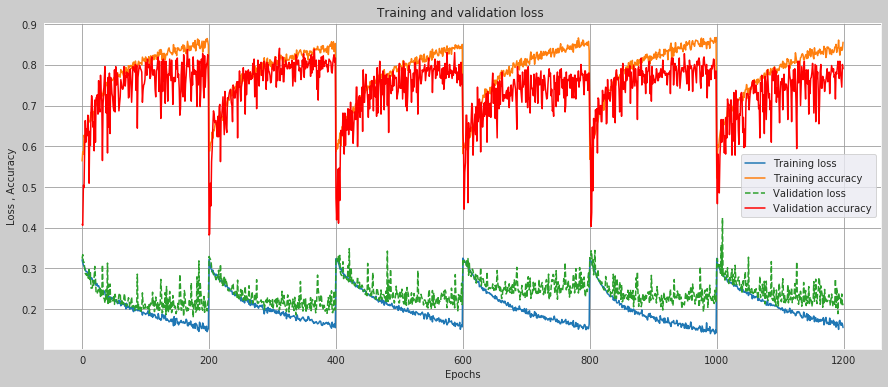

In [43]:
# In[16]:

# ### TRAINING HISTORY

print(model_selection,model_number)

csv_df = pd.read_csv('models/' + model_selection + '_' + model_number + '_history.csv')
history_csv = csv_df[csv_df.columns[1:]].to_dict(orient='list')

skip = 1
loss_history_csv = history_csv['loss']
acc_history_csv = history_csv['categorical_accuracy']
val_loss_history_csv = history_csv['val_loss']
val_acc_history_csv = history_csv['val_categorical_accuracy']
epochs_csv = range(0, len(loss_history_csv) , skip)  

fig, ax = plt.subplots(ncols=1, nrows=1,facecolor=(.8, .8, .8), figsize=[15,6])
ax.set_facecolor('w')
ax.plot(epochs_csv, loss_history_csv[0::skip], '-', label='Training loss') 
ax.plot(epochs_csv, acc_history_csv[0::skip], '-', label='Training accuracy') 
ax.plot(epochs_csv, val_loss_history_csv[0::skip], '--', label='Validation loss')
ax.plot(epochs_csv, val_acc_history_csv[0::skip], '-r', label='Validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss , Accuracy')
ax.grid(b=True, which='major', color=(.6, .6, .6), linestyle='-')
ax.set_title('Training and validation loss ')
ax.legend()

plt.savefig('models/' + model_selection + '_' + model_number + '_history_csv.png')

validation_minimum = np.argmin(val_loss_history_csv)
print(f"Validation minimum reached at epoch {validation_minimum}")
accuracy_maximum = np.argmax(val_acc_history_csv)
print(f"Validation maximum reached at epoch {accuracy_maximum}")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Train set = 1887
Train steps = 145
Valid set = 378
Valid steps = 29
  ...
    to  
  ['...']
145/145 [==============================] - 196s 1s/step - loss: 0.1146 - categorical_accuracy: 0.8801
  ...
    to  
  ['...']
29/29 [==============================] - 91s 3s/step - loss: 0.2077 - categorical_accuracy: 0.7719
Valid_1 steps = 378
Train set = 1887
Train steps = 145
Valid set = 378
Valid steps = 29
  ...
    to  
  ['...']
145/145 [==============================] - 41s 280ms/step - loss: 0.1136 - categorical_accuracy: 0.9066
  ...
    to  
  ['...']
29/29 [==============================] - 17s 587ms/step - loss: 0.2165 - categorical_accuracy: 0.8090
Valid_1 steps = 378
Train set = 1887
Train steps = 145
Valid set = 378
Valid steps = 29
  ...
    to  
  ['...']
145/145 [==============================] - 40s 276ms/step - loss: 0.1210 - 

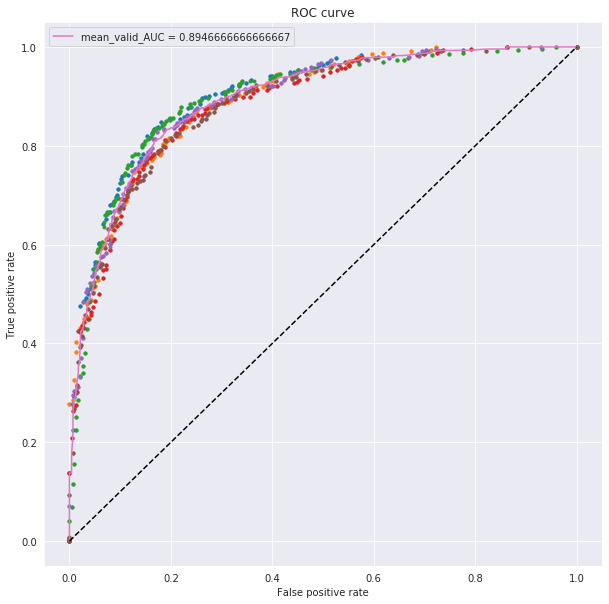

In [45]:
### In[17]:

# ### Evaluation of k-fold validation sets
fit_cycles = NSPLITS
train_scores = np.zeros((fit_cycles,2))
valid_scores = np.zeros((fit_cycles,2))
valid_auc_rocs = np.zeros((fit_cycles,1))
valid_precision = np.zeros((fit_cycles,1))
valid_recall = np.zeros((fit_cycles,1))
valid_f1_score = np.zeros((fit_cycles,1))
tpr_rf = np.empty(0)
fpr_rf = np.empty(0)
cm = np.empty((2,2,fit_cycles))

K.clear_session()

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    wst_model = WaveletScatteringTransform(input_shape=(HEIGHT, WIDTH, CHANNELS),
                                           upsample=UPSAMPLE,
                                           upsample_kernel=UPSAMPLE_KERNEL)

    resnet_model_0 = ResNet(input_shape_1=(RESNET_DIM_1, RESNET_DIM_2, WSTCHANNELS),
                           input_shape_2=(RESNET_DIM_1, RESNET_DIM_2, 1),
                           num_class=NUM_CLASS,
                           ks1=KS1, ks2=KS2, ks3=KS3, 
                           dl1=DL1, dl2=DL2, dl3=DL3,
                           filters=NF,resblock1=NR1,
                           r_filters=NFL, resblock2=NR2,
                           dil_mode=DIL_MODE, 
                           sp_dropout=DR1,re_dropout=DR2,
                           prep=PREP,
                           stem=STEM,
                           mask_float=MSK_FLOAT,
                           mask_threshold=MSK_THRESHOLD,
                           att=ATT,
                           head_size=HEAD_SIZE,
                           num_heads=NUM_HEAD,
                           value_att=VALUE_ATT,
                           scale_by_input=SCALE_BY_INPUT,
                           scale_threshold=SCALE_THRESHOLD,
                           scale_to_span=SCALE_TO_SPAN,
                           span=SPAN,                            
                           blur_sbi=BLUR_SBI,
                           blur_sbi_std=BLUR_SBI_STD,                                                                 
                           return_seq=True)
    
    
    # ROC curve figure initialization
    plt.figure(1, figsize=(10, 10))
    
    for i in range(fit_cycles):            

        # Reinitialize the generators and store the permuted lists
        with open('models/' + model_selection + '_' + model_number + '_M' + str(i) + "_train_set.json", 'r') as filehandle:
            train_set = json.load(filehandle)        
        with open('models/' + model_selection + '_' + model_number + '_M' + str(i) + "_valid_set.json", 'r') as filehandle:
            valid_set = json.load(filehandle) 
                      
        wst_input_1 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
        wst_input_2 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
        wst_output_1 = wst_model([wst_input_1,wst_input_2])
        resnet_model = clone_model(resnet_model_0)
        resnet_model.load_weights('models/' + model_selection + '_' + model_number + '_M' + str(i) + '_resnet_weights.h5')
        resnet_output = resnet_model(wst_output_1)
        model = Model([wst_input_1,wst_input_2], resnet_output,name='wst_resnet')
        
        model.compile(optimizer=OPTIMIZER, 
                      loss=tf.keras.losses.CategoricalCrossentropy(), 
                      metrics=[tf.keras.metrics.CategoricalAccuracy()]) 
        
        # GENERATORS for TRAIN and VALID IMAGES sets evaluation        
        train_generator = DataGenerator(train_set['train'], datadir, augment=False, shuffle=False, standard=False,\
                                              batch_size=PERM_TRAIN_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS), \
                                              mask_dim=(HEIGHT, WIDTH, 1), \
                                              mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, \
                                              verbose=0)            

        valid_generator = DataGenerator(valid_set['valid'], datadir, augment=False, shuffle=False, standard=False,\
                                              batch_size=PERM_VALID_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS), \
                                              mask_dim=(HEIGHT, WIDTH, 1), \
                                              mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, \
                                              verbose=0)

        # Individual sets evaluation
        print(f"Train set = {len(train_set['train'])}")
        print(f"Train steps = {len(train_generator)}")        
        print(f"Valid set = {len(valid_set['valid'])}")
        print(f"Valid steps = {len(valid_generator)}")
            
        train_scores[i,:]=model.evaluate(train_generator,steps=len(train_generator))    
        # print(f"Non-augmented M{str(i)} Cross Validation score = {train_scores[i,:]}")
        valid_scores[i,:]=model.evaluate(valid_generator,steps=len(valid_generator))    
        # print(f"Non-augmented M{str(i)} Cross Validation score = {valid_scores[i,:]}")
        

        # GENERATORS for VALID IMAGES one at a time (for ROC curve and Confusion matrix)                
        valid_1_generator = DataGenerator(valid_set["valid"], datadir, augment=False, shuffle=False, standard=False,\
                                              batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                              mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)                

        print(f"Valid_1 steps = {len(valid_1_generator)}")
              
        labels = ['Positive','Negative']

        valid_y_true = []
        valid_y_pred = []

        for j in range(len(valid_set["valid"])):
            x_m, y, w = valid_1_generator.__getitem__(j)
            valid_y_true.append(y[0].tolist())
            y_pred = model(x_m).numpy().tolist()
            valid_y_pred.append(y_pred[0])

        valid_y_true = np.array(valid_y_true)
        valid_y_pred = np.array(valid_y_pred)                

        valid_auc_rocs[i],fpr_rf_array,tpr_rf_array = get_multi_roc_curve_sequence(labels, valid_y_pred, valid_y_true)

        fpr_rf = np.concatenate((fpr_rf,fpr_rf_array))        
        tpr_rf = np.concatenate((tpr_rf,tpr_rf_array))
        
        valid_precision[i], valid_recall[i], valid_f1_score[i] = \
            other_metrics_binary_class(valid_y_true[:,0],valid_y_pred[:,0],0.5)
        
        # Confusion matrix
        one_ind = np.argmax(valid_y_pred,axis=1)
        valid_y_pred_mat = np.zeros_like(valid_y_pred)
        for k in range(len(valid_y_pred)):
            valid_y_pred_mat[k,one_ind[k]]=1

        # print(valid_y_pred_mat.shape)        
        cm[:,:,i] = confusion_matrix(np.argmax(valid_y_true,axis=1),\
                              np.argmax(valid_y_pred,axis=1))                
        
        del model                            

# ROC curve (continue plotting) 
fpr_rf = np.sort(fpr_rf)
tpr_rf = np.sort(tpr_rf)    
plt.plot(fpr_rf,tpr_rf,'-',label="mean_valid_AUC = " + str(valid_auc_rocs.mean()))

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='upper left')    
# plt.show()
plt.savefig('models/' + model_selection + '_' + model_number + '_Mean_Validation_ROC.png')                            
              

In [46]:
# In[18]:

# ### Evaluation
# print(f"Training scores = {train_scores}")    
# print(f"Validation scores = {valid_scores}")              
mean_train_scores = np.mean(train_scores,axis=0)
mean_valid_scores = np.mean(valid_scores,axis=0)
std_train_scores = np.std(train_scores,axis=0)
std_valid_scores = np.std(valid_scores,axis=0)
print(f"\nMean training scores (loss,accuracy) = {mean_train_scores}")              
print(f"Mean validation scores (loss,accuracy) = {mean_valid_scores}")              
print(f"Mean validation AUC = {str(valid_auc_rocs.mean())}")
print(f"Mean validation precision = {valid_precision.mean()}")
print(f"Mean validation recall = {valid_recall.mean()}")
print(f"Mean validation F1 score = {valid_f1_score.mean()}")
print(f"\nStd training scores (loss,accuracy) = {std_train_scores}")              
print(f"Std validation scores (loss,accuracy) = {std_valid_scores}")              
print(f"Std validation AUC = {str(valid_auc_rocs.std())}")
print(f"Std validation precision = {valid_precision.std()}")
print(f"Std validation recall = {valid_recall.std()}")
print(f"Std validation F1 score = {valid_f1_score.std()}")



Mean training scores (loss,accuracy) = [0.11040861 0.90300619]
Mean validation scores (loss,accuracy) = [0.20902182 0.81299735]
Mean validation AUC = 0.8946666666666667
Mean validation precision = 0.7401065151664722
Mean validation recall = 0.7930985031304846
Mean validation F1 score = 0.7593736157521646

Std training scores (loss,accuracy) = [0.00981266 0.01867952]
Std validation scores (loss,accuracy) = [0.01031166 0.0196567 ]
Std validation AUC = 0.00654896090146284
Std validation precision = 0.05603191888975927
Std validation recall = 0.0894509661628652
Std validation F1 score = 0.025231685160664874


Confusion matrix, without normalization
[[112  29]
 [ 42 194]]


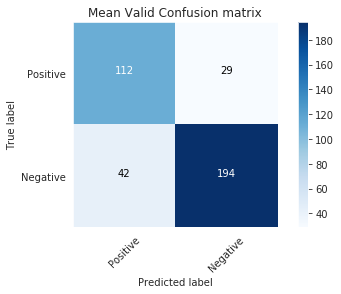

In [55]:
# Non-Normalized Mean Confusion matrix
cm_mean = np.uint32(np.mean(cm,axis=2).round())
cm_plot_labels = ['Positive','Negative']
plot_confusion_matrix(cm_mean, cm_plot_labels,title='Mean Valid Confusion matrix')
plt.gcf()
plt.savefig('models/' + model_selection + '_' + model_number + '_Mean_Validation_Confusion_matrix.png', dpi=200)                     

Confusion matrix, without normalization
[[ 674  174]
 [ 251 1166]]


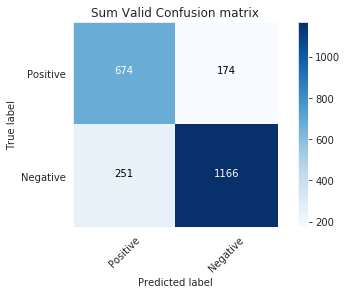

In [56]:
# Non-Normalized Sum Confusion Matrix              
cm_sum = np.uint32(np.sum(cm,axis=2))
cm_plot_labels = ['Positive','Negative']
plot_confusion_matrix(cm_sum, cm_plot_labels,title='Sum Valid Confusion matrix')
plt.gcf()
plt.savefig('models/' + model_selection + '_' + model_number + '_Sum_Validation_Confusion_matrix.png', dpi=200)

Confusion matrix, without normalization
[[0.298 0.077]
 [0.111 0.515]]


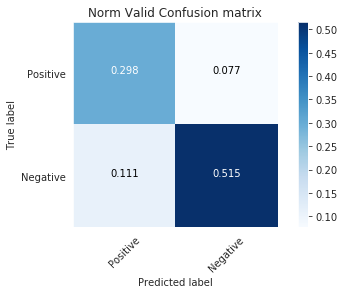

In [57]:
# Normalized Confusion matrix
cm_sum = np.sum(cm,axis=2)
cm_mean = cm_sum/len(dataset['train'])
cm_mean = np.around(cm_mean, decimals=3, out=None)

cm_plot_labels = ['Positive','Negative']
plot_confusion_matrix(cm_mean, cm_plot_labels,title='Norm Valid Confusion matrix')
plt.gcf()
plt.savefig('models/' + model_selection + '_' + model_number + '_Norm_Validation_Confusion_matrix.png', dpi=200) 

In [44]:
# In[19]:

# ### ENSEMBLE MODEL
K.clear_session()

if SCALE_BY_INPUT:
    loi = 'multiply_2'
else:
    loi = 'multiply_1'

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  
    # MODELS

    wst_model = WaveletScatteringTransform(input_shape=(HEIGHT, WIDTH, CHANNELS),
                                           upsample=UPSAMPLE,
                                           upsample_kernel=UPSAMPLE_KERNEL)

    resnet_model = ResNet(input_shape_1=(RESNET_DIM_1, RESNET_DIM_2, WSTCHANNELS),
                           input_shape_2=(RESNET_DIM_1, RESNET_DIM_2, 1),
                           num_class=NUM_CLASS,
                           ks1=KS1, ks2=KS2, ks3=KS3, 
                           dl1=DL1, dl2=DL2, dl3=DL3,
                           filters=NF,resblock1=NR1,
                           r_filters=NFL, resblock2=NR2,
                           dil_mode=DIL_MODE, 
                           sp_dropout=DR1,re_dropout=DR2,
                           prep=PREP,
                           stem=STEM,
                           mask_float=MSK_FLOAT,
                           mask_threshold=MSK_THRESHOLD,
                           att=ATT,
                           head_size=HEAD_SIZE,
                           num_heads=NUM_HEAD,
                           value_att=VALUE_ATT,
                           scale_by_input=SCALE_BY_INPUT,
                           scale_threshold=SCALE_THRESHOLD,
                           scale_to_span=SCALE_TO_SPAN,
                           span=SPAN,                          
                           blur_sbi=BLUR_SBI,
                           blur_sbi_std=BLUR_SBI_STD,                                                                 
                           return_seq=True)

    # recover individual resnet models
    resnet_model_0 = clone_model(resnet_model)
    resnet_model_0.load_weights('models/' + model_selection + '_' + model_number + '_M0' + '_resnet_weights.h5')
    
    for layer in resnet_model_0.layers:
        layer.trainable = False                
    resnet_model__0 = Model(inputs=[resnet_model_0.inputs], 
                            outputs=[resnet_model_0.get_layer(loi).output])    

    
    resnet_model_1 = clone_model(resnet_model)
    resnet_model_1.load_weights('models/' + model_selection + '_' + model_number + '_M1' + '_resnet_weights.h5')
    
    for layer in resnet_model_1.layers:
        layer.trainable = False                
    resnet_model__1 = Model(inputs=[resnet_model_1.inputs], 
                            outputs=[resnet_model_1.get_layer(loi).output]) 

    
    resnet_model_2 = clone_model(resnet_model)
    resnet_model_2.load_weights('models/' + model_selection + '_' + model_number + '_M2' + '_resnet_weights.h5')
    
    for layer in resnet_model_2.layers:
        layer.trainable = False                
    resnet_model__2 = Model(inputs=[resnet_model_2.inputs], 
                            outputs=[resnet_model_2.get_layer(loi).output])

    
    resnet_model_3 = clone_model(resnet_model)
    resnet_model_3.load_weights('models/' + model_selection + '_' + model_number + '_M3' + '_resnet_weights.h5')
    
    for layer in resnet_model_3.layers:
        layer.trainable = False                
    resnet_model__3 = Model(inputs=[resnet_model_3.inputs], 
                            outputs=[resnet_model_3.get_layer(loi).output]) 

    
    resnet_model_4 = clone_model(resnet_model)
    resnet_model_4.load_weights('models/' + model_selection + '_' + model_number + '_M4' + '_resnet_weights.h5')
    
    for layer in resnet_model_4.layers:
        layer.trainable = False                
    resnet_model__4 = Model(inputs=[resnet_model_4.inputs], 
                            outputs=[resnet_model_4.get_layer(loi).output])     

    
    resnet_model_5 = clone_model(resnet_model)
    resnet_model_5.load_weights('models/' + model_selection + '_' + model_number + '_M5' + '_resnet_weights.h5')
    
    for layer in resnet_model_5.layers:
        layer.trainable = False                
    resnet_model__5 = Model(inputs=[resnet_model_5.inputs], 
                            outputs=[resnet_model_5.get_layer(loi).output]) 
    

    # GRAPH 1
    
    wst_input_1 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    wst_input_2 = Input(shape=(HEIGHT, WIDTH, CHANNELS)) 
    
    wst_output_1 = wst_model([wst_input_1,wst_input_2])    
    
    y0 = resnet_model__0(wst_output_1)
    y1 = resnet_model__1(wst_output_1)    
    y2 = resnet_model__2(wst_output_1)
    y3 = resnet_model__3(wst_output_1)
    y4 = resnet_model__4(wst_output_1)
    y5 = resnet_model__5(wst_output_1)    
    
    d3 = Average()([y0,y1,y2,y3,y4,y5])     
    
    d3 = GlobalAveragePooling2D()(d3)
    
    resnet_output = Activation("softmax", name = 'softmax')(d3)     
    

    ensemble_model = Model([wst_input_1,wst_input_2], resnet_output,name='ensemble_wst_resnet')  

    ensemble_model.compile(optimizer=Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy()]) 

print(wst_model.name + ' model selected')
print(ensemble_model.name + ' model selected')    


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
WST model selected
ensemble_wst_resnet model selected


In [64]:
ensemble_model.summary()

Model: "ensemble_wst_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
WST (Model)                     (None, 75, 85, 50)   0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 75, 85, 2)    20467       WST[1][0]      

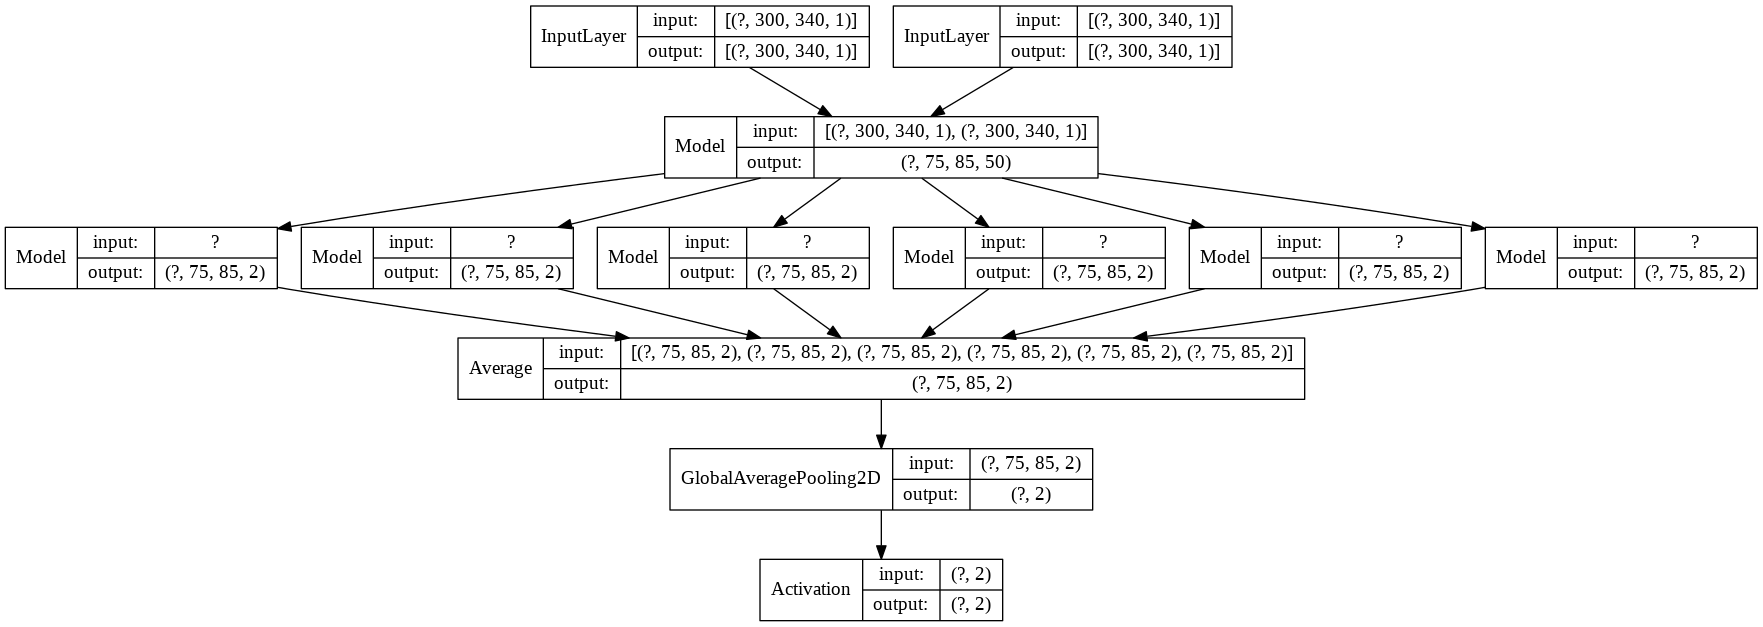

In [65]:
plot_model(ensemble_model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_ensemble_wst_resnet_architecture.png')

In [66]:
# In[20]:

# SAVE H5 FORMAT
# ensemble_model.save('models/ensemble_' + model_selection + '_' + model_number + '_all' + '.h5',
#         overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)

# SAVE WEIGHTS
ensemble_model.save_weights('models/ensemble_' + model_selection + '_' + model_number + '_weights' + '.h5')


In [45]:
# Get generators for training and validation/test sets. Set standard=False if the images were 
# already standardized.     
        
print(TRAIN_SIZE,VAL_SIZE)

train_generator = DataGenerator(dataset["train"], datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=TRAIN_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)
valid_generator = DataGenerator(dataset["valid"], datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=VAL_SIZE, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)                                      


15 15


In [46]:
# In[21]
    
# ### EVALUATION

train_scores=ensemble_model.evaluate(train_generator,steps=len(train_generator))    
print('Non-augmented Train score = ',train_scores)
valid_scores=ensemble_model.evaluate(valid_generator,steps=len(valid_generator))    
print('Non-augmented Validation score = ',valid_scores)


  ...
    to  
  ['...']
151/151 [==============================] - 69s 460ms/step - loss: 0.0958 - categorical_accuracy: 0.9280
Non-augmented Train score =  [0.09577744935225967, 0.9280353]
  ...
    to  
  ['...']
102/102 [==============================] - 51s 503ms/step - loss: 0.2535 - categorical_accuracy: 0.7889
Non-augmented Validation score =  [0.25354421339636923, 0.7888889]


In [51]:
# ### GENERATOR for POSITIVE and NEGATIVE IMAGES one at a time

datadir = H5_IMAGE_DIR
                                      
train_1_generator = DataGenerator(dataset["train"], datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)
valid_1_generator = DataGenerator(dataset["valid"], datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)


In [52]:
print(len(dataset["train"]),len(dataset["valid"]))

2265 1532


In [53]:
TRAIN_SIZE * len(train_generator)

2265

In [54]:
VAL_SIZE * len(valid_generator)

1530

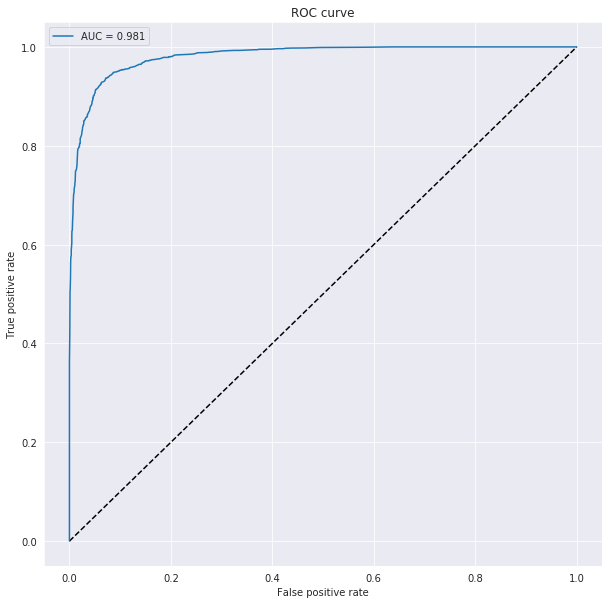

train_precision =  0.8778877887788779
train_recall =  0.9410377358490566
train_F1 score =  0.9083665338645418


In [73]:
# In[22]: 
    
# ### TRAIN SET ROC CURVE 

labels = ['Positive','Negative']

train_y_true = []
train_y_pred = []

for i in range(len(dataset["train"])):
    x_m, y, w = train_1_generator.__getitem__(i)
    train_y_true.append(y[0].tolist())
    y_pred = ensemble_model(x_m).numpy().tolist()
    train_y_pred.append(y_pred[0])
    
train_y_true = np.array(train_y_true)
train_y_pred = np.array(train_y_pred)

train_auc_rocs = get_mean_roc_curve_sequence(labels, train_y_pred, train_y_true)

train_precision, train_recall, train_f1_score = \
    other_metrics_binary_class(train_y_true[:,0],train_y_pred[:,0],0.5)

print('train_precision = ', train_precision)
print('train_recall = ', train_recall)
print('train_F1 score = ', train_f1_score)


(2265, 2)
[[ 798   50]
 [ 113 1304]]
Confusion matrix, without normalization
[[ 798   50]
 [ 113 1304]]


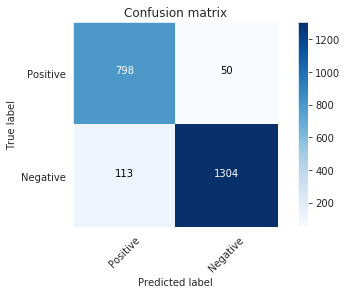

In [74]:
# In[23]:

# ### Confusion matrix

one_ind = np.argmax(train_y_pred,axis=1)
train_y_pred_mat = np.zeros_like(train_y_pred)
for i in range(len(train_y_pred)):
    train_y_pred_mat[i,one_ind[i]]=1

print(train_y_pred_mat.shape)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(train_y_true,axis=1),\
                      np.argmax(train_y_pred,axis=1))

print(cm)

cm_plot_labels = ['Positive','Negative']

# Plot normalized confusion matrix
plot_confusion_matrix(cm, cm_plot_labels,title='Confusion matrix')
plt.gcf()
plt.savefig('models/' + model_selection + '_' + model_number + '_Confusion_matrix_training.png', dpi=200)


In [75]:
# ### TRAINING SET GENERATOR for POSITIVE and NEGATIVE IMAGES one at a time

# List of positive and negative training images
train_pos_list = np.array(dataset["train"])[train_y_true[:,0]==1].tolist()
train_neg_list = np.array(dataset["train"])[train_y_true[:,1]==1].tolist()

datadir = H5_IMAGE_DIR
                                      
train_pos_generator = DataGenerator(train_pos_list, datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)
train_neg_generator = DataGenerator(train_neg_list, datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)


In [ ]:
# In[24]:

# # ### DIRECTORY TO SAVE HEAT MAPS
pwd = os.getcwd()
os.system('mkdir large_set_gradcam_train')
gradcam_path = os.path.join(pwd,'large_set_gradcam_train/')
os.system('mkdir large_set_gradcam_train/positive')
OUT_IMAGE_DIR = os.path.join(gradcam_path,'positive/')
print(H5_IMAGE_DIR)
print(OUT_IMAGE_DIR)

FIG_SIZE = (16,20)

_HEAT_MAP_DIFF(ensemble_model,generator=train_pos_generator,layer='average',\
          labels=['Positive score','Negative score'],header='LABELED: POSITIVE',figsize=FIG_SIZE,\
          image_dir=H5_IMAGE_DIR,out_image_dir=OUT_IMAGE_DIR,\
          img_list=train_pos_list,first_img=30,last_img=50,\
          img_width=WIDTH,img_height=HEIGHT,display=True)


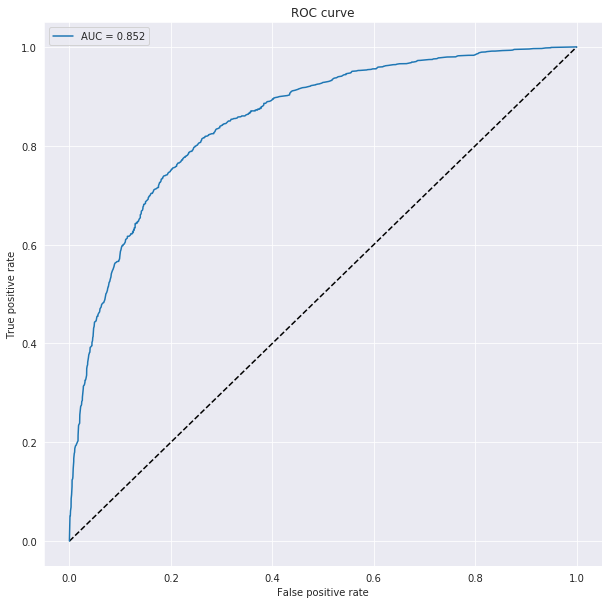

valid_precision =  0.7386569872958257
valid_recall =  0.6933560477001703
valid_F1 score =  0.7152899824253075


In [55]:
# In[25]:

# IMPORTANT: in this and following cells what is called 'valid' set is actually the 'test' set.
    
# ### TEST SET ROC CURVE  

labels = ['Positive', 'Negative']

valid_y_true = []
valid_y_pred = []

for i in range(len(dataset["valid"])):
    x_m, y, w = valid_1_generator.__getitem__(i)
    valid_y_true.append(y[0].tolist())
    y_pred = ensemble_model(x_m).numpy().tolist()
    valid_y_pred.append(y_pred[0])
    
valid_y_true = np.array(valid_y_true)
valid_y_pred = np.array(valid_y_pred)

valid_auc_rocs = get_mean_roc_curve_sequence(labels, valid_y_pred, valid_y_true)

valid_precision, valid_recall, valid_f1_score = \
    other_metrics_binary_class(valid_y_true[:,0],valid_y_pred[:,0],0.5)

print('valid_precision = ', valid_precision)
print('valid_recall = ', valid_recall)
print('valid_F1 score = ', valid_f1_score)


(1532, 2)
[[407 180]
 [144 801]]
Confusion matrix, without normalization
[[407 180]
 [144 801]]


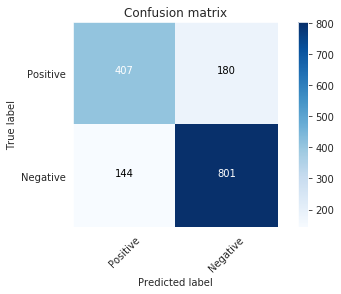

In [56]:
# In[25]:

# ### Confusion matrix

one_ind = np.argmax(valid_y_pred,axis=1)
valid_y_pred_mat = np.zeros_like(valid_y_pred)
for i in range(len(valid_y_pred)):
    valid_y_pred_mat[i,one_ind[i]]=1

print(valid_y_pred_mat.shape)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(valid_y_true,axis=1),\
                      np.argmax(valid_y_pred,axis=1))

print(cm)

cm_plot_labels = ['Positive','Negative']

# Plot normalized confusion matrix
plot_confusion_matrix(cm, cm_plot_labels,title='Confusion matrix')
plt.gcf()
plt.savefig('models/' + model_selection + '_' + model_number + '_Confusion_matrix_test.png', dpi=200)


In [57]:
# ### TEST SET GENERATOR for POSITIVE and NEGATIVE IMAGES one at a time

# List of positive and negative images
valid_pos_list = np.array(dataset["valid"])[valid_y_true[:,0]==1].tolist()
valid_neg_list = np.array(dataset["valid"])[valid_y_true[:,1]==1].tolist()

datadir = H5_IMAGE_DIR
                                      
valid_pos_generator = DataGenerator(valid_pos_list, datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)
valid_neg_generator = DataGenerator(valid_neg_list, datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)


In [58]:
print(len(valid_pos_list),len(valid_neg_list))

587 945


In [ ]:
# In[27]:

# ### DIRECTORY TO SAVE HEAT MAPS
pwd = os.getcwd()
os.system('mkdir large_set_gradcam_valid_WST_RESNET')
gradcam_path = os.path.join(pwd,'large_set_gradcam_valid_WST_RESNET/')
os.system('mkdir large_set_gradcam_valid_WST_RESNET/positive')
OUT_IMAGE_DIR = os.path.join(gradcam_path,'positive/')
print(H5_IMAGE_DIR)
print(OUT_IMAGE_DIR)

FIG_SIZE = (16,20)

_HEAT_MAP_DIFF(ensemble_model,generator=valid_pos_generator,layer='average',\
          labels=['Positive score','Negative score'],header='LABELED: POSITIVE',figsize=FIG_SIZE,\
          image_dir=H5_IMAGE_DIR,out_image_dir=OUT_IMAGE_DIR,\
          img_list=valid_pos_list,first_img=0,last_img=len(valid_pos_list),\
          img_width=WIDTH,img_height=HEIGHT,display=False)


In [ ]:
# In[28]:
    
# ### DIRECTORY TO SAVE HEAT MAPS
pwd = os.getcwd()
os.system('mkdir large_set_gradcam_valid_WST_RESNET')
gradcam_path = os.path.join(pwd,'large_set_gradcam_valid_WST_RESNET/')
os.system('mkdir large_set_gradcam_valid_WST_RESNET/negative')
OUT_IMAGE_DIR = os.path.join(gradcam_path,'negative/')
print(H5_IMAGE_DIR)
print(OUT_IMAGE_DIR)

FIG_SIZE = (16,20)

_HEAT_MAP_DIFF(ensemble_model,generator=valid_neg_generator,layer='average',\
          labels=['Positive score','Negative score'],header='LABELED: NEGATIVE',figsize=FIG_SIZE,\
          image_dir=H5_IMAGE_DIR,out_image_dir=OUT_IMAGE_DIR,\
          img_list=valid_neg_list,first_img=0,last_img=len(valid_neg_list),\
          img_width=WIDTH,img_height=HEIGHT,display=False)


In [61]:
# In[29]:

# ### CHECK ON IMAGE WRITING

path = "large_set_gradcam_valid_WST_RESNET/positive"
dirs = os.listdir( path )
print(len(valid_pos_list),len(dirs))

path = "large_set_gradcam_valid_WST_RESNET/negative"
dirs = os.listdir( path )
print(len(valid_neg_list),len(dirs))


587 587
945 945
